<a href="https://colab.research.google.com/github/ksricharank/confidence/blob/master/XgBoost_confidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, sys
nb_path = '/content/drive/MyDrive/Research'
sys.path.insert(0,nb_path)
print(sys.path)

['/content/drive/MyDrive/Research', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [6]:
!pip install '/content/drive/MyDrive/Research/xgboost-1.4.0_SNAPSHOT+cb207a355d1ff530b5f9a7dcb8677dc19999e270-py3-none-manylinux2010_x86_64.whl'

Processing ./drive/MyDrive/Research/xgboost-1.4.0_SNAPSHOT+cb207a355d1ff530b5f9a7dcb8677dc19999e270-py3-none-manylinux2010_x86_64.whl
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [5]:
import xgboost as xgb
print(xgb.__version__)

1.4.0-SNAPSHOT


In [6]:
from ConfidenceScores import custom_add
custom_add.cadd(2,2)

4

# Start of Confidence Scores section


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import xgboost
from sklearn import metrics
from sklearn.datasets import fetch_openml

In [8]:
mnist = fetch_openml('mnist_784', cache=True)
print(mnist.data.shape, mnist.target.shape)

(70000, 784) (70000,)


In [9]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [10]:
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(52500, 784) (17500, 784) (52500,) (17500,)


### Default XGBoost implementation

In [13]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 5,                 # the maximum depth of each tree
    'eta': 0.5,                     # the training step for each iteration
    'eta_decay': 0.9,
    'min_eta': 0.05,
    'silent': 0,                    # logging mode - quiet
    'objective': 'multi:softmax',   # multiclass classification using the softmax objective
    'num_class': 10,                 # the number of classes that exist in this datset
    'early_stopping_rounds': 10,
    'n_estimators': 5000
}  

def eval_acc(preds, dtrain):
    labels = dtrain.get_label()
    return 'acc', metrics.accuracy_score(labels, preds), 
    

results = {}
model = xgboost.train(params, dtrain, num_boost_round=2, evals=[(dval, 'val')], evals_result=results, feval=eval_acc)

[19:02:38] WARNING: ../src/learner.cc:547: 
Parameters: { early_stopping_rounds, eta_decay, min_eta, n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: ignored

### Confidence score XGBoost implementation

In [14]:
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax as softmax_matrix

n_classes = 10
eps=10**-10

def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)

def sigmoid(x):
    '''Sigmoid function with x as input vector.'''
    e = 1/(1 + np.exp(-x)) 
    return e

dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 5,                 # the maximum depth of each tree
    'eta': 0.5,                     # the training step for each iteration
    'eta_decay': 0.9,
    'min_eta': 0.05,
    'silent': 0,                    # logging mode - quiet
    'num_class': n_classes+1,       # the number of classes that exist in this datset
    'early_stopping_rounds': 10,
    'n_estimators': 5000
}  

In [15]:
# custom
def obj_w_confidence__log_regularizer(preds_w_conf, dtrain):
    
    lam = 0.5
    labels = dtrain.get_label().reshape(-1, 1)
    labels = OneHotEncoder(sparse=False, categories='auto').fit_transform(labels)
    
    preds = preds_w_conf[:,:-1]
    conf = preds_w_conf[:,-1]
    
    preds = softmax_matrix(preds, axis=1)
    weights = np.tile(sigmoid(conf),[n_classes,1]).T
    loss = np.sum(-1.*labels*np.log(preds+eps),axis=1)
    
    preds_grad = weights*(preds - labels)
    conf_grad = loss*sigmoid(conf)*(1-sigmoid(conf)) - lam*sigmoid(-1.*conf)
    grad = np.hstack([preds_grad, conf_grad[:,np.newaxis]])

    preds_hess = 2.0 * weights * preds * (1.0 - preds)
    conf_hess = loss*sigmoid(conf)*(1-sigmoid(conf))*(1-2*sigmoid(conf)) + lam*sigmoid(-1.*conf)*(1-sigmoid(-1.*conf))
    hess = np.hstack([preds_hess, conf_hess[:,np.newaxis]])

    return grad.flatten(), hess.flatten()

def obj_w_confidence__linear_regularizer(preds_w_conf, dtrain):

    lam = 1.
    labels = dtrain.get_label().reshape(-1, 1)
    labels = OneHotEncoder(sparse=False, categories='auto').fit_transform(labels)
    
    preds = preds_w_conf[:,:-1]
    conf = preds_w_conf[:,-1]
    
    preds = softmax_matrix(preds, axis=1)
    weights = np.tile(sigmoid(conf),[n_classes,1]).T
    loss = np.sum(-1.*labels*np.log(preds+eps),axis=1)
    
    preds_grad = weights*(preds - labels)
    conf_grad = (loss-lam)*sigmoid(conf)*(1-sigmoid(conf)) 
    grad = np.hstack([preds_grad, conf_grad[:,np.newaxis]])

    preds_hess = 2.0 * weights * preds * (1.0 - preds)
    conf_hess = (loss-lam)*sigmoid(conf)*(1-sigmoid(conf))*(1-2*sigmoid(conf)) 
    hess = np.hstack([preds_hess, conf_hess[:,np.newaxis]])

    return grad.flatten(), hess.flatten()

In [16]:
def eval_acc(preds_w_conf, dtrain):
    labels = dtrain.get_label()
    preds = preds_w_conf[:,:-1]

    one_hot_labels = OneHotEncoder(sparse=False, categories='auto').fit_transform(labels.reshape(-1, 1))
    preds = softmax_matrix(preds, axis=1)

    log_loss = np.mean(np.sum(-1.*one_hot_labels*np.log(preds+eps),axis=1))
    conf_loss = -1.*np.mean(np.log(sigmoid(preds_w_conf[:,-1])))
    conf_mean = np.mean(sigmoid(preds_w_conf[:,-1]))
    print("log_loss = ", log_loss)
    print("conf_loss = ", conf_loss)
    print("conf_mean = ", conf_mean)

    preds = np.argmax(preds,axis=1)
    return 'acc', metrics.accuracy_score(labels, preds)

In [17]:
results = {}
model = xgboost.train(params, dtrain, num_boost_round=50, obj = obj_w_confidence__linear_regularizer, evals=[(dval, 'val')], evals_result=results, feval=eval_acc)

[19:03:00] WARNING: ../src/learner.cc:547: 
Parameters: { early_stopping_rounds, eta_decay, min_eta, n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:03:13] WARNING: ../src/learner.cc:1043: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss =  1.0591982041495187
conf_loss =  0.47407689690589905
conf_mean =  0.62245935
[0]	val-mlogloss:1.12975	val-acc:0.82091
log_loss =  0.7753117494872638
conf_loss =  0.0759894922375679
conf_mean =  0.92682576
[1]	val-mlogloss:1.17638	val-acc:0.87183
log_loss =  0.6047871416649648
conf_loss =  0.04303230717778206
conf_mean =  0.95788026
[2]	val-mlogloss:1.1

### Validation Section

In [ ]:
preds_w_conf = model.predict(dval,output_margin=True)
preds = preds_w_conf[:,:-1]
conf = preds_w_conf[:,-1]
    
preds = softmax_matrix(preds, axis=1)
conf = sigmoid(conf)
pred_class = np.argmax(preds,axis=1)
pred_prob = np.max(preds,axis=1)
#pred_aum
pred_class_top_2 = np.partition(-preds, 2, axis = 1)[:,:2]
pred_aum = np.abs(np.diff(pred_class_top_2,axis=1))

In [ ]:
k=25
idx = np.argpartition(conf, k)
print(idx[:k])

[ 8247 12027 14248 12288  1026  3234 10075 17201 15378  7640  8010  8770
 17378 11189 10355  6446  7104 17383 12645 11842  7538  4935  4860 11677
 13325]


In [ ]:
np.mean(conf[idx[:k]])

0.3878859

In [ ]:
from matplotlib import pyplot as plt
for i in idx[:k]:
  image = X_val[i]
  
  print("Actual class", y_val[i])
  print("Predicted class:", pred_class[i])
  print("Predicted class confidence:", pred_prob[i])
  print("Predicted aum:", pred_aum[i])
  print("Confidence score:", conf[i])
  
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()

### Metrics section

In [ ]:
from sklearn.metrics import roc_auc_score
target = [1-int(x) for x in (y_val - pred_class)!=0]

print("AUC: Predicted class confidence:", roc_auc_score(target, pred_prob))
print("AUC: Predicted aum:", roc_auc_score(target, pred_aum))
print("AUC: Confidence score:", roc_auc_score(target, conf))

AUC: Predicted class confidence: 0.9582320431844888
AUC: Predicted aum: 0.9580268923815118
AUC: Confidence score: 0.6832392650802978


## Comparison with Fashion MNIST

In [ ]:
from sklearn.datasets import fetch_openml
fmnist = fetch_openml('fashion-MNIST', cache=True)
print(fmnist.data.shape, fmnist.target.shape)

(70000, 784) (70000,)


In [ ]:
X = fmnist.data[:100].astype('float32')
y = fmnist.target[:100].astype('int64')
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [ ]:
dood = xgboost.DMatrix(X, label=y)

In [ ]:
preds_w_conf = model.predict(dood,output_margin=True)
preds = preds_w_conf[:,:-1]
conf = preds_w_conf[:,-1]
    
preds = softmax_matrix(preds, axis=1)
conf = sigmoid(conf)
pred_class = np.argmax(preds,axis=1)
pred_prob = np.max(preds,axis=1)
#pred_aum
pred_class_top_2 = np.partition(-preds, 2, axis = 1)[:,:2]
pred_aum = np.abs(np.diff(pred_class_top_2,axis=1))

In [ ]:
np.mean(conf)

0.99997467

Actual class 19
Predicted class: 8
Predicted class confidence: 0.99339867
Predicted aum: [0.9890084]
Confidence score: 0.99995697


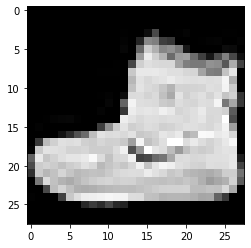

Actual class 10
Predicted class: 8
Predicted class confidence: 0.99987036
Predicted aum: [0.99980253]
Confidence score: 0.9999608


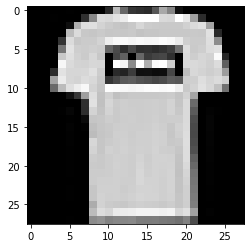

Actual class 10
Predicted class: 8
Predicted class confidence: 0.99995613
Predicted aum: [0.9999324]
Confidence score: 0.9999809


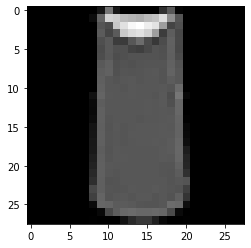

Actual class 13
Predicted class: 8
Predicted class confidence: 0.9999647
Predicted aum: [0.99993366]
Confidence score: 0.9999809


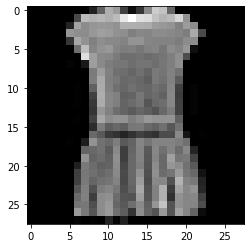

Actual class 10
Predicted class: 8
Predicted class confidence: 0.9999809
Predicted aum: [0.99997026]
Confidence score: 0.99997544


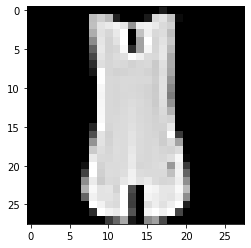

Actual class 12
Predicted class: 8
Predicted class confidence: 0.999958
Predicted aum: [0.9999272]
Confidence score: 0.9999795


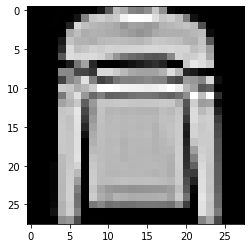

Actual class 17
Predicted class: 2
Predicted class confidence: 0.99913627
Predicted aum: [0.99854803]
Confidence score: 0.99998343


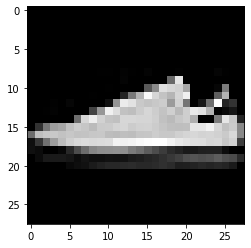

Actual class 12
Predicted class: 8
Predicted class confidence: 0.9959931
Predicted aum: [0.9942553]
Confidence score: 0.99996614


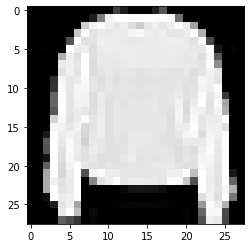

Actual class 15
Predicted class: 2
Predicted class confidence: 0.4422722
Predicted aum: [0.19115627]
Confidence score: 0.99997914


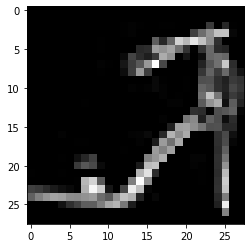

Actual class 15
Predicted class: 2
Predicted class confidence: 0.9532648
Predicted aum: [0.92219293]
Confidence score: 0.9999783


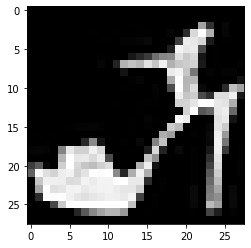

Actual class 10
Predicted class: 8
Predicted class confidence: 0.99999905
Predicted aum: [0.99999845]
Confidence score: 0.99997294


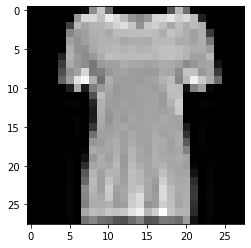

Actual class 19
Predicted class: 2
Predicted class confidence: 0.58743614
Predicted aum: [0.18015712]
Confidence score: 0.9999541


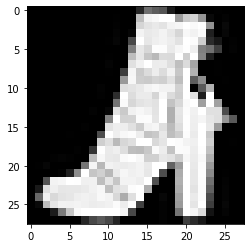

Actual class 15
Predicted class: 2
Predicted class confidence: 0.96066755
Predicted aum: [0.93985826]
Confidence score: 0.9999845


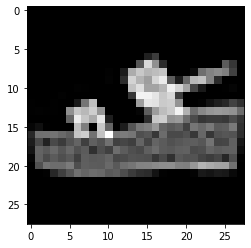

Actual class 15
Predicted class: 0
Predicted class confidence: 0.9635018
Predicted aum: [0.9282813]
Confidence score: 0.99998367


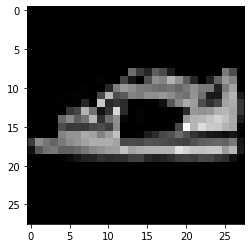

Actual class 17
Predicted class: 2
Predicted class confidence: 0.9570683
Predicted aum: [0.9168459]
Confidence score: 0.9999802


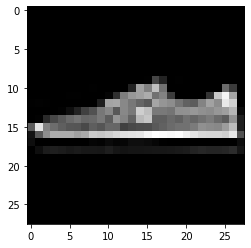

Actual class 19
Predicted class: 8
Predicted class confidence: 0.71019876
Predicted aum: [0.42147923]
Confidence score: 0.999984


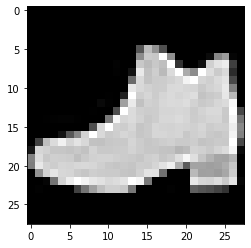

Actual class 11
Predicted class: 8
Predicted class confidence: 0.98833054
Predicted aum: [0.97916174]
Confidence score: 0.99997914


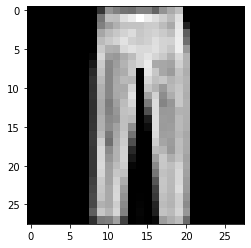

Actual class 10
Predicted class: 8
Predicted class confidence: 0.99998045
Predicted aum: [0.99997085]
Confidence score: 0.99997294


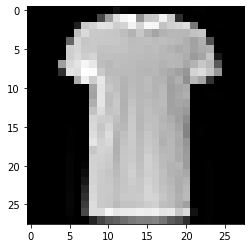

Actual class 16
Predicted class: 8
Predicted class confidence: 0.9999781
Predicted aum: [0.9999679]
Confidence score: 0.99997294


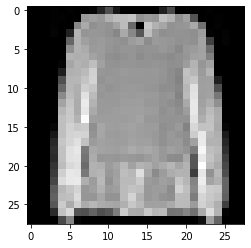

Actual class 14
Predicted class: 8
Predicted class confidence: 0.99667394
Predicted aum: [0.99459964]
Confidence score: 0.9999211


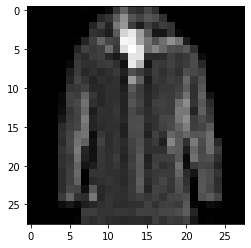

Actual class 13
Predicted class: 8
Predicted class confidence: 0.99895155
Predicted aum: [0.9979977]
Confidence score: 0.9999753


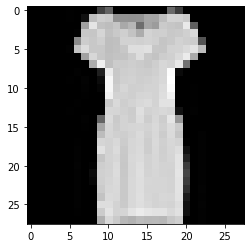

Actual class 11
Predicted class: 8
Predicted class confidence: 0.99793124
Predicted aum: [0.9966223]
Confidence score: 0.9999827


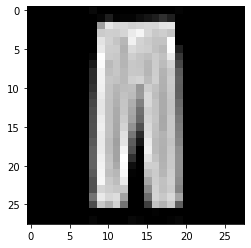

Actual class 14
Predicted class: 8
Predicted class confidence: 0.998922
Predicted aum: [0.9981279]
Confidence score: 0.99998116


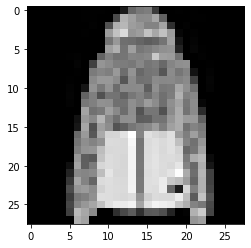

Actual class 18
Predicted class: 8
Predicted class confidence: 0.9998551
Predicted aum: [0.99972093]
Confidence score: 0.9999666


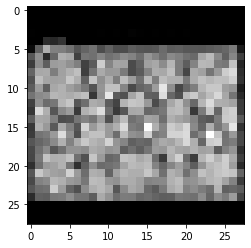

Actual class 14
Predicted class: 8
Predicted class confidence: 0.99928397
Predicted aum: [0.99885887]
Confidence score: 0.99997294


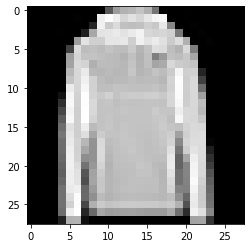

In [ ]:
from matplotlib import pyplot as plt
for i in range(k):
  image = X[i]
  
  print("Actual class", 10+y[i])
  print("Predicted class:", pred_class[i])
  print("Predicted class confidence:", pred_prob[i])
  print("Predicted aum:", pred_aum[i])
  print("Confidence score:", conf[i])
  
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()